
<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Artificial Intelligence <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Spring 2025<br>
<font color=3C99D size=5>
    Project-Phase1<br>
    Image Segmentation<br>
<font color=696880 size=4>
    Shayan Baghayi Nejad-Armin Khosravi


<font size=5 color=cyan> Names: امیرحسین محمدزاده - امیرمهدی طهماسبی - محمدنوید آتشین بار

Student Numbers: 402106434 - 402106178 - 402105581 </font>

# Introduction

In this Project, we will become familiar with UNet architecture, Attention mechanism, and Residual blocks with the help of which we will build UNet, AttentionUNet, and ResidualAttentionUnet from scratch using PyTorch framework. The built models will be evaluated by various metrics such as accuracy, Iou score, and Dice score.

### Environment Setup

Here you will find the required packages. Feel free to add the list.

In [ ]:
!~/venvs/jupyter/bin/pip install kagglehub torch torchvision tqdm matplotlib

  Using cached kagglehub-0.3.13-py3-none-any.whl.metadata (38 kB)
  Using cached kagglehub-0.3.13-py3-none-any.whl.metadata (38 kB)
  Using cached torch-2.8.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (30 kB)
  Using cached torchvision-0.23.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (6.1 kB)
  Using cached torch-2.8.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (30 kB)
  Using cached torchvision-0.23.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (6.1 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached filelock-3.19.1-py3-none-any.whl.metadata (2.1 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached filelock-3.19.1-py3-none-any.whl.metadata (2.1 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached fsspe

In [1]:
import os
import shutil
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import kagglehub
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim import Adam
from tqdm import tqdm
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Hyperparameter Setting

Place your hyperparameters' values in the cell below.

In [2]:
DATA_DIR = './data'
IMAGE_SIZE = (256,256)
BATCH_SIZE = 8
NUM_WORKERS = 2
LR = 1e-3
NUM_EPOCHS = 10

# Data Preparation

Our task is to segment the [Massachusetts Road Dataset](https://www.kaggle.com/datasets/balraj98/massachusetts-roads-dataset). You can download this dataset by placing your API Token from kaggle in ```~/.kaggle/``` folder (Instructions can be found in the Kaggle website) and then running the code below.

In [3]:
path = kagglehub.dataset_download("balraj98/massachusetts-roads-dataset")
print("Path to dataset files:", path)
DATA_DIR = path

Using Colab cache for faster access to the 'massachusetts-roads-dataset' dataset.
Path to dataset files: /kaggle/input/massachusetts-roads-dataset


If you are running on colab, it is highly recommended to save the dataset to your drive to avoid problems when disconnecting from runtime.

### Loading Images

Load the images and their corresponding masks in two separate lists. (The cell below might take some time to execute.)

In [4]:
def load_images_and_masks(images_path, masks_path, image_size):
    """
    Loads and preprocesses images and their corresponding masks.

    Args:
        images_path (str): Path to the directory containing input images.
        masks_path (str): Path to the directory containing corresponding masks.
        image_size (tuple): Desired size (width, height) to resize images and masks.

    Returns:
        images (np.array or list): Loaded and resized images.
        masks (np.array or list): Loaded and resized masks.
    """
    images = [(Image.open(image_file).convert('RGB')).resize(image_size, Image.BILINEAR) for image_file in images_path]
    masks = [(Image.open(mask_file).convert('L')).resize(image_size) for mask_file in masks_path]

    return np.array(images), np.array(masks)


# Define training image and mask directories
train_images_dir = os.path.join(DATA_DIR, 'tiff/train')
train_masks_dir = os.path.join(DATA_DIR, 'tiff/train_labels')

# Get paths or filenames for training images and masks (placeholder)
train_images_path = [os.path.join(train_images_dir, file) for file in sorted(os.listdir(train_images_dir))]
train_masks_path = [os.path.join(train_masks_dir, file) for file in sorted(os.listdir(train_masks_dir))]

# Load and preprocess training images and masks
train_images, train_masks = load_images_and_masks(train_images_path, train_masks_path, IMAGE_SIZE)

# Define validation image and mask directories
val_images_dir = os.path.join(DATA_DIR, 'tiff/val')
val_masks_dir = os.path.join(DATA_DIR, 'tiff/val_labels')

# Get paths or filenames for validation images and masks (placeholder)
val_images_path = [os.path.join(val_images_dir, file) for file in sorted(os.listdir(val_images_dir))]
val_masks_path = [os.path.join(val_masks_dir, file) for file in sorted(os.listdir(val_masks_dir))]

# Load and preprocess validation images and masks
val_images, val_masks = load_images_and_masks(val_images_path, val_masks_path, IMAGE_SIZE)

### Data Visualization

Display the images and their masks for several samples.

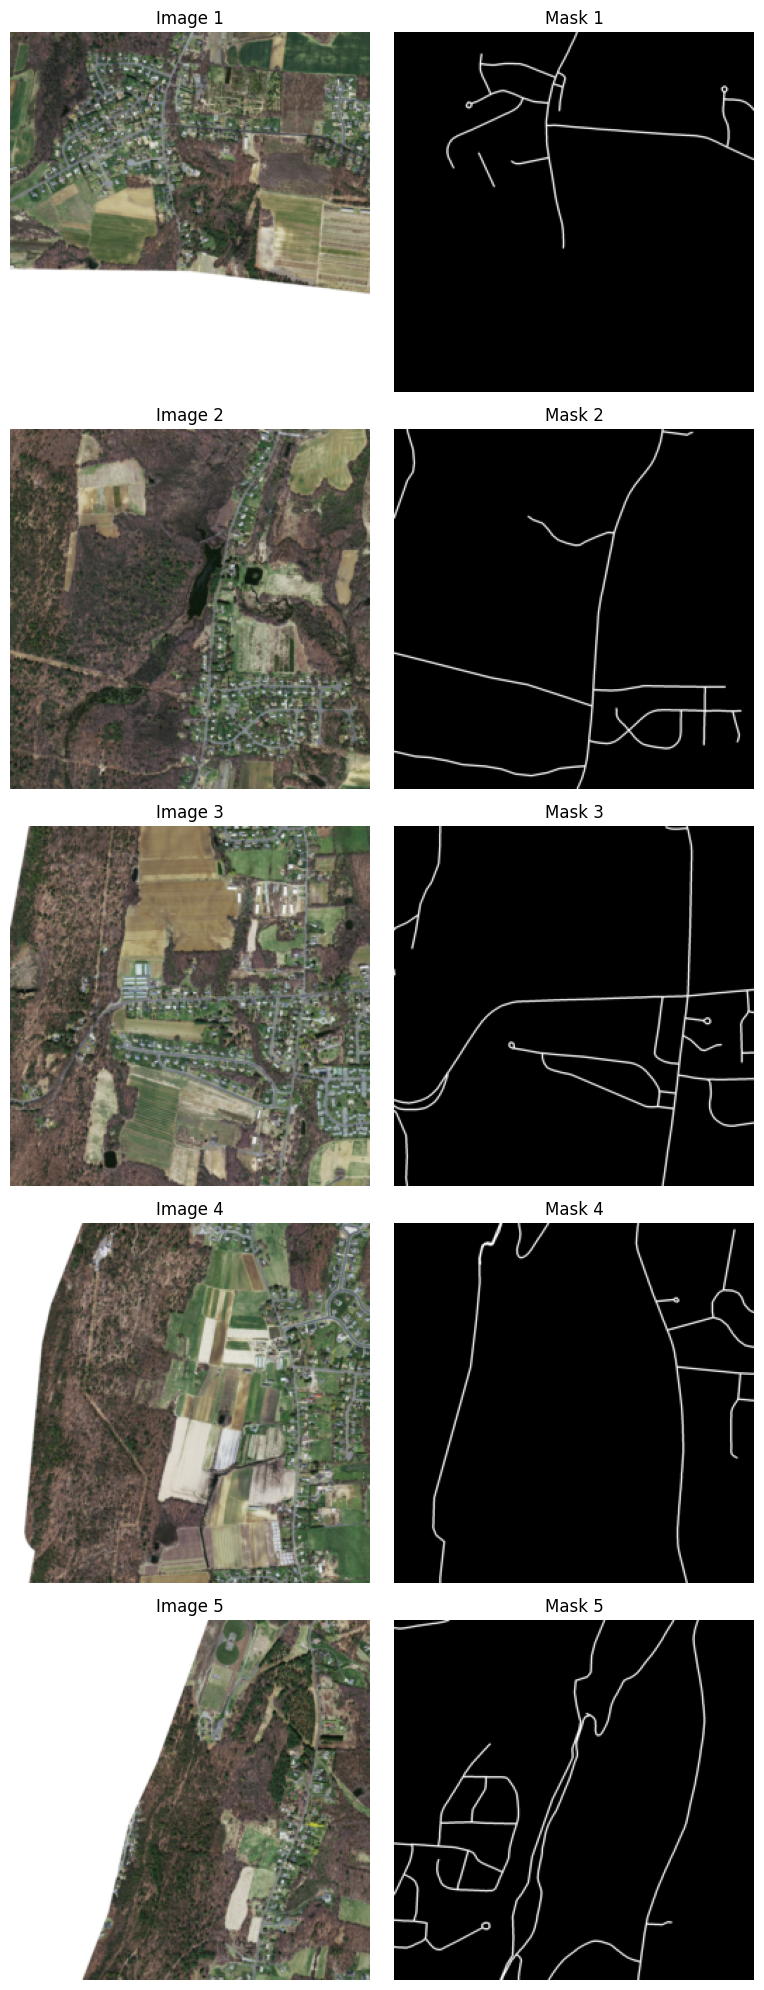

In [5]:
def visualize_images_and_masks(images, masks, n=5):
    """
    Visualizes 'n' images and their corresponding masks side by side.

    Args:
        images (array-like): Collection of input images.
        masks (array-like): Collection of corresponding mask images.
        n (int): Number of image-mask pairs to display.
    """
    plt.figure(figsize=(8, 4 * n))

    for i in range(n):
        plt.subplot(n, 2, 2 * i + 1)
        plt.imshow(images[i])
        plt.title(f'Image {i+1}')
        plt.axis('off')

        plt.subplot(n, 2, 2 * i + 2)
        plt.imshow(masks[i], cmap='gray')
        plt.title(f'Mask {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_images_and_masks(train_images[0 : 5], train_masks[0 : 5])

### Dataset Creation

Finally, we will make the dataset using the list of images we have stored.

In [6]:
class RoadDataset(Dataset):
    """
    Custom Dataset class for loading road images and their corresponding masks.

    Args:
        images (array-like): List or array of input images.
        masks (array-like): List or array of corresponding masks.
        image_transform (callable, optional): Transformation to apply to the images.
        mask_transform (callable, optional): Transformation to apply to the masks.
    """
    def __init__(self, images, masks, image_transform=None, mask_transform=None):
        self.images = images
        self.masks = masks
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask


### Define your desired transformations
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0).float()) # Apply binary conversion to tensor
])


train_dataset = RoadDataset(train_images, train_masks, image_transform, mask_transform)
val_dataset   = RoadDataset(val_images, val_masks, image_transform, mask_transform)

train_loader  = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader    = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False,num_workers=NUM_WORKERS)

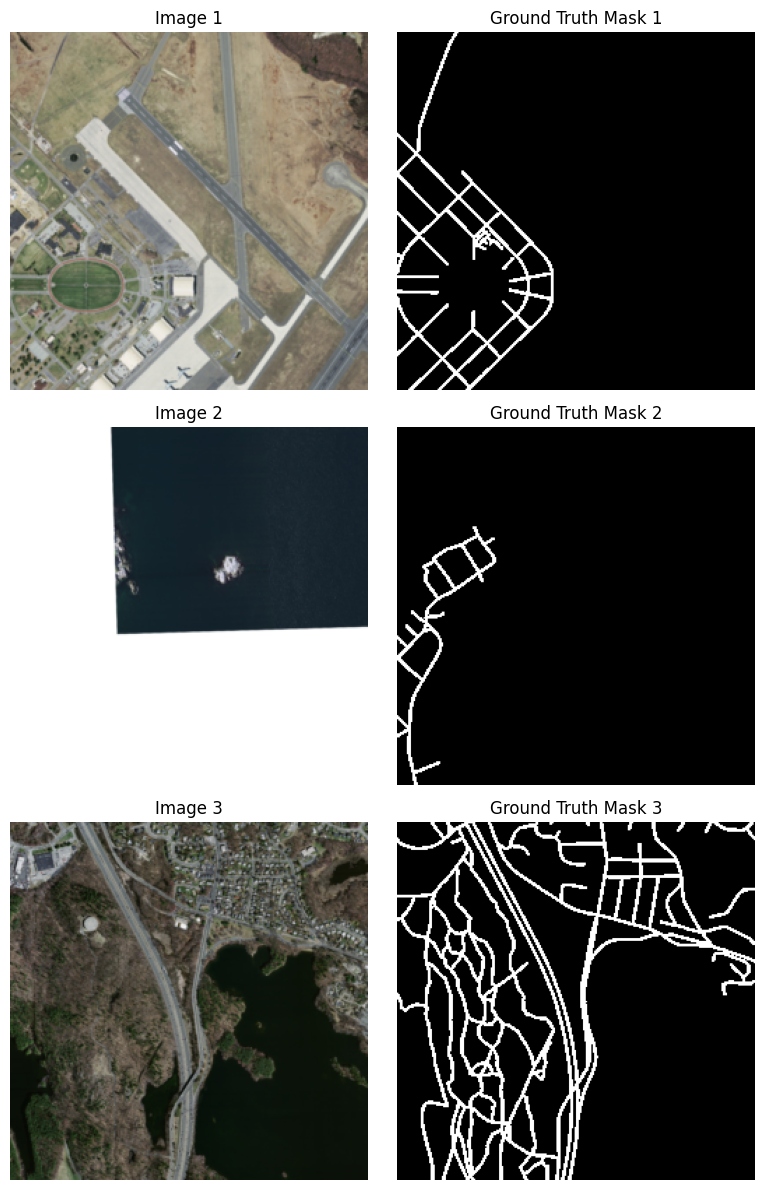

In [7]:
def visualize_images_and_masks_only(images, masks, n=5):
    plt.figure(figsize=(8, 4 * n))

    for i in range(n):
        # Original Image
        plt.subplot(n, 2, 2 * i + 1)
        plt.imshow(images[i])
        plt.title(f'Image {i+1}')
        plt.axis('off')

        # Ground Truth Mask
        plt.subplot(n, 2, 2 * i + 2)
        plt.imshow(masks[i], cmap='gray')
        plt.title(f'Ground Truth Mask {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Get a batch from the train_loader
sample_images, sample_masks = next(iter(train_loader))

# Denormalize images for better visualization
mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
sample_images_denorm = sample_images * std + mean

# Convert tensors to numpy arrays for visualization
sample_images_np = sample_images_denorm.permute(0, 2, 3, 1).cpu().numpy()
sample_masks_np = sample_masks.squeeze().cpu().numpy()

# Visualize
visualize_images_and_masks_only(sample_images_np, sample_masks_np, n=3)

# UNet

Before proceeding, it is necessary to understand the idea behind UNet. In order to avoid too much details in this notebook, you can read the complete paper for UNet from [this link](https://arxiv.org/pdf/1505.04597).

The overall structure of UNet is provided in the image below.

![UNet Architecture](https://viso.ai/wp-content/uploads/2024/04/unet-process.png)

### Convolution Block

Convolution block is used at each level of UNet.

In [8]:
class ConvBlock(nn.Module):
    """
    A convolutional block consisting of multiple layers (e.g., Conv2D, BatchNorm, ReLU).

    Args:
        in_channel (int): Number of input channels.
        out_channel (int): Number of output channels.
    """
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.conv = nn.Sequential(
            # First Conv => Normalize => ReLU
            nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True),
            # Second Conv => Normalize => ReLU
            nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
      return self.conv(x)

### Up Convoluitional Block

We use another block to upsample the latent vector.

In [9]:
class UpConvBlock(nn.Module):
    """
    An upsampling block used in decoder parts of segmentation networks like U-Net.

    Args:
        in_channel (int): Number of input channels.
        out_channel (int): Number of output channels.
    """
    def __init__(self, in_channel, out_channel):
      super().__init__()
      self.upconv = nn.Sequential(
          nn.ConvTranspose2d(in_channel, out_channel, kernel_size=2, stride=2)
      )

    def forward(self, x):
      return self.upconv(x)

### Complete UNet Structure

Now using the ```ConvBlock``` and ```UpConvBlock``` you created, complete the UNet architecture.

In [10]:
class UNet(nn.Module):
    """
    U-Net architecture for image segmentation tasks.

    Args:
        in_channel (int): Number of input channels (e.g., 3 for RGB images).
        out_channel (int): Number of output channels (e.g., 1 for binary segmentation).
        filter (list): List of filter sizes for each level of the encoder/decoder.
    """
    def __init__(self, in_channel=3, out_channel=1, filter=[64, 128, 256, 512]):
        super().__init__()
        self.encode_1 = ConvBlock(in_channel, filter[0])
        self.encode_2 = ConvBlock(filter[0], filter[1])
        self.encode_3 = ConvBlock(filter[1], filter[2])
        self.encode_4 = ConvBlock(filter[2], filter[3])

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = ConvBlock(filter[3], filter[3] * 2)

        self.upsample_4 = UpConvBlock(filter[3] * 2, filter[3])
        self.upsample_3 = UpConvBlock(filter[3], filter[2])
        self.upsample_2 = UpConvBlock(filter[2], filter[1])
        self.upsample_1 = UpConvBlock(filter[1], filter[0])

        self.decode_4 = ConvBlock(filter[3] * 2, filter[3])
        self.decode_3 = ConvBlock(filter[3], filter[2])
        self.decode_2 = ConvBlock(filter[2], filter[1])
        self.decode_1 = ConvBlock(filter[1], filter[0])

        self.final_conv = nn.Conv2d(filter[0], out_channel, kernel_size=1)

    def forward(self, x):
        encode1 = self.encode_1(x)
        pool1 = self.pool(encode1)
        encode2 = self.encode_2(pool1)
        pool2 = self.pool(encode2)
        encode3 = self.encode_3(pool2)
        pool3 = self.pool(encode3)
        encode4 = self.encode_4(pool3)
        pool4 = self.pool(encode4)

        bottleneck = self.bottleneck(pool4)

        upsample4 = self.upsample_4(bottleneck)
        concat4 = torch.cat((upsample4, encode4), dim=1)
        decode4 = self.decode_4(concat4)
        upsample3 = self.upsample_3(decode4)
        concat3 = torch.cat((upsample3, encode3), dim=1)
        decode3 = self.decode_3(concat3)
        upsample2 = self.upsample_2(decode3)
        concat2 = torch.cat((upsample2, encode2), dim=1)
        decode2 = self.decode_2(concat2)
        upsample1 = self.upsample_1(decode2)
        concat1 = torch.cat((upsample1, encode1), dim=1)
        decode1 = self.decode_1(concat1)

        final_conv = self.final_conv(decode1)
        return final_conv

# Attention UNet

### Attention Mechanism

Attention UNet uses this mechanism to know what part the image is more important to attend to. You can read about this mechanism from [this link](https://arxiv.org/pdf/1706.03762). The Attention mechanism in UNet is described in [this paper](https://arxiv.org/pdf/1804.03999).


![Attention](https://www.researchgate.net/publication/373655981/figure/fig3/AS:11431281186315360@1693879045519/Visualization-of-attention-blocks-reveals-their-functionality-While-the-self-attention.png)

In [11]:
class AttentionBlock(nn.Module):
    """
    Attention block for focusing on relevant features in skip connections.

    Args:
        f_g (int): Number of channels in the gating signal (from decoder).
        f_l (int): Number of channels in the skip connection input (from encoder).
        f_int (int): Number of intermediate channels used within the attention block.
    """
    def __init__(self, f_g, f_l, f_int):
        super().__init__()

        self.w_g = nn.Sequential(
            nn.Conv2d(f_g, f_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(f_int)
        )

        self.w_x = nn.Sequential(
            nn.Conv2d(f_l, f_int, kernel_size=1, stride=2, padding=0, bias=True),
            nn.BatchNorm2d(f_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(f_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        # Print dimension of g and x
        # print("Dimension of g:", g.shape)
        # print("Dimension of x:", x.shape)
        g1 = self.w_g(g)
        x1 = self.w_x(x)
        # print("Dimension of g1:", g1.shape)
        # print("Dimension of x1:", x1.shape)
        psi = self.psi(self.relu(g1 + x1))
        # print("Dimension of psi:", psi.shape)
        # apply bilinear interpolation : resize back to x's
        psi = F.interpolate(psi, x.size()[2:], mode='bilinear', align_corners=True)
        return x * psi

Now use the ```AttentionBlock``` to inherit [Attention UNet](https://arxiv.org/pdf/1804.03999) from UNet.

![Attention UNet](https://www.researchgate.net/publication/347344899/figure/fig6/AS:971357475069952@1608601077414/The-architecture-of-Attention-U-Net-Attention-gate-selects-features-by-using-the.png)

In [12]:
class AttentionUNet(UNet):  # Inherits from UNet
    """
    Attention U-Net architecture which extends the basic U-Net
    by integrating attention blocks in the skip connections.

    Args:
        in_channel (int): Number of input channels.
        out_channel (int): Number of output channels.
        filter_sizes (list): List of filter sizes for each level.
    """
    def __init__(self, in_channel=3, out_channel=1, filter_sizes=[64, 128, 256, 512]):
        super().__init__(in_channel, out_channel, filter_sizes)
        self.attention4 = AttentionBlock(filter_sizes[3] * 2, filter_sizes[3], filter_sizes[3])
        self.attention3 = AttentionBlock(filter_sizes[3], filter_sizes[2], filter_sizes[2])
        self.attention2 = AttentionBlock(filter_sizes[2], filter_sizes[1], filter_sizes[1])
        self.attention1 = AttentionBlock(filter_sizes[1], filter_sizes[0], filter_sizes[0])


    def forward(self, x):
        encode1 = self.encode_1(x)
        pool1 = self.pool(encode1)
        encode2 = self.encode_2(pool1)
        pool2 = self.pool(encode2)
        encode3 = self.encode_3(pool2)
        pool3 = self.pool(encode3)
        encode4 = self.encode_4(pool3)
        pool4 = self.pool(encode4)

        bottleneck = self.bottleneck(pool4)

        upsample4 = self.upsample_4(bottleneck)
        attention4 = self.attention4(bottleneck, encode4)
        concat4 = torch.cat((upsample4, attention4), dim=1)
        decode4 = self.decode_4(concat4)

        upsample3 = self.upsample_3(decode4)
        attention3 = self.attention3(decode4, encode3)
        concat3 = torch.cat((upsample3, attention3), dim=1)
        decode3 = self.decode_3(concat3)

        upsample2 = self.upsample_2(decode3)
        attention2 = self.attention2(decode3, encode2)
        concat2 = torch.cat((upsample2, attention2), dim=1)
        decode2 = self.decode_2(concat2)

        upsample1 = self.upsample_1(decode2)
        attention1 = self.attention1(decode2, encode1)
        concat1 = torch.cat((upsample1, attention1), dim=1)
        decode1 = self.decode_1(concat1)

        final_conv = self.final_conv(decode1)

        return final_conv

# Residual Attention UNet

We will add residual blocks to the attention for better gradient flow. You can read more about residual blocks [here](https://arxiv.org/pdf/1512.03385).

<img src="https://dfzljdn9uc3pi.cloudfront.net/2023/cs-1302/1/fig-1-full.png" width="400" alt="ResUNet Architecture">

In [13]:
class ResidualConvBlock(nn.Module):
    """
    Residual convolutional block with skip connection.

    Args:
        in_channel (int): Number of input channels.
        out_channel (int): Number of output channels.
    """
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channel)
        )
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channel)
        ) if in_channel != out_channel else nn.Identity()

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = self.shortcut(x)
        out = self.conv1(x)
        out = self.conv2(out)
        out += residual
        return self.relu(out)

Use ```ResidualConvBlock``` to construct Residual Attention Unet.

In [14]:
class ResidualAttentionUNet(AttentionUNet):
    """
    Residual Attention U-Net combining residual blocks with attention mechanisms.

    Args:
        in_channel (int): Number of input channels.
        out_channel (int): Number of output channels.
        filter_sizes (list): List of filter sizes for each level.
    """
    def __init__(self, in_channel=3, out_channel=1, filter_sizes=[64, 128, 256, 512]):
        super().__init__(in_channel, out_channel, filter_sizes)

        self.encode_1 = ResidualConvBlock(in_channel, filter_sizes[0])
        self.encode_2 = ResidualConvBlock(filter_sizes[0], filter_sizes[1])
        self.encode_3 = ResidualConvBlock(filter_sizes[1], filter_sizes[2])
        self.encode_4 = ResidualConvBlock(filter_sizes[2], filter_sizes[3])

        self.bottleneck = ResidualConvBlock(filter_sizes[3], filter_sizes[3] * 2)

        self.decode_4 = ResidualConvBlock(filter_sizes[3] * 2, filter_sizes[3])
        self.decode_3 = ResidualConvBlock(filter_sizes[3], filter_sizes[2])
        self.decode_2 = ResidualConvBlock(filter_sizes[2], filter_sizes[1])
        self.decode_1 = ResidualConvBlock(filter_sizes[1], filter_sizes[0])

    def forward(self, x):
        return super().forward(x)

# Training

Now it is time to train the model on training data.

### Loss Function

We will be using the sum of [Dice Score](https://oecd.ai/en/catalogue/metrics/dice-score#:~:text=The%20Dice%20score%20is%20calculated,sizes%20of%20the%20two%20sets.), [Iou Score](https://www.v7labs.com/blog/intersection-over-union-guide), and Binary Cross Entropy as loss function. You can read about the mentioned scores in the provided links.

<font color=cyan><b> Note: Do Not Change The ```OverallLoss``` Function as it is used for measuring you model's performance.</b></font>

In [15]:
### DICE LOSS
class DiceLoss(nn.Module):
    """
    Dice Loss for measuring overlap between predicted and ground truth masks.
    Particularly useful for imbalanced classes in segmentation tasks.

    Args:
        smooth (float): Small constant to avoid division by zero.
    """
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, real):
        fpred = pred.view(-1)
        freal = real.view(-1)
        sum_of_sizes = fpred.sum() + freal.sum()
        intersection = (fpred * freal).sum()
        dice_coeff = (2 * intersection + self.smooth) / (sum_of_sizes + self.smooth)
        return 1 - dice_coeff


### Iou Loss
class IouLoss(nn.Module):
    """
    Intersection over Union (IoU) Loss for segmentation evaluation.
    Measures the overlap between predicted and ground truth masks.

    Args:
        smooth (float): Small constant to avoid division by zero.
    """
    def __init__(self, smooth=1e-6):
        super(IouLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, real):
        fpred = pred.view(-1)
        freal = real.view(-1)
        intersection = (fpred * freal).sum()
        union = fpred.sum() + freal.sum() - intersection
        iou_coeff = (intersection + self.smooth) / (union + self.smooth)
        return 1 - iou_coeff


### Overall Loss (DO NOT CHANGE)
class OverallLoss(nn.Module):
    """
    Combined loss function that sums Dice loss, IoU loss, and Binary Cross-Entropy loss.

    Args:
        smooth (float): Small constant to avoid division by zero.
    """
    def __init__(self, smooth=1e-6):
        super(OverallLoss, self).__init__()
        self.dice_loss = DiceLoss(smooth)
        self.iou_loss = IouLoss(smooth)
        self.bce_loss = nn.BCELoss()

    def forward(self, pred, real):
        dice = self.dice_loss(pred, real)
        iou = self.iou_loss(pred, real)
        bce = self.bce_loss(pred, real)

        return dice, iou, bce, dice+iou+bce

### Training Epoch

Complete the function below to train the model for one epoch.

In [16]:
def train_one_epoch(model, optimizer, criterion, data_loader, scheduler=None, device='cuda'):
    """
    Trains the model for one epoch.

    Args:
        model (nn.Module): The neural network model to train.
        optimizer (torch.optim.Optimizer): Optimizer for updating model parameters.
        criterion (nn.Module): Loss function to compute the loss.
        data_loader (DataLoader): DataLoader providing training batches.
        scheduler (optional): Learning rate scheduler.
        device (str): Device to run the training on ('cuda' or 'cpu').

    Returns:
        float: Average loss over the epoch.
    """

    total_loss = 0.0
    model.train()
    for i, (img, mask) in enumerate(tqdm(data_loader)):
        # Move the image and mask to device
        img = img.to(device)
        mask = mask.to(device)
        # Set the gradients to zero
        optimizer.zero_grad()
        # Predict the mask using the model
        pred = model(img)
        # Apply sigmoid to get probabilities for BCE loss
        pred = torch.sigmoid(pred)
        # Compute the loss
        _, _, _, loss = criterion(pred, mask)
        # Compute gradients
        loss.backward()
        # Update the parameters
        optimizer.step()

        if scheduler:
            # Schedule the learning rate
            scheduler.step()

        total_loss += loss.item()

    return total_loss/len(data_loader)

Design a function for evaluation after each training phase.

In [17]:
def evaluate_model(model, criterion, data_loader, device='cuda'):
    """
    Evaluates the model on validation or test data.

    Args:
        model (nn.Module): The neural network model to evaluate.
        criterion (nn.Module): Loss function to compute evaluation metrics.
        data_loader (DataLoader): DataLoader providing evaluation batches.
        device (str): Device to run evaluation on ('cuda' or 'cpu').

    Returns:
        tuple: Average loss, average IoU score, and average Dice score over the dataset.
    """
    total_loss = 0.0
    iou_score = 0.0
    dice_score = 0.0
    model.eval()

    with torch.no_grad():
        for i, (img, mask) in enumerate(tqdm(data_loader)):
            # Move the image and mask to device
            img = img.to(device)
            mask = mask.to(device)

            # Predict the mask
            pred = model(img)
            # Apply sigmoid to get probabilities for BCE loss
            pred = torch.sigmoid(pred)

            # Compute the loss
            dice_loss, iou_loss, bce_loss, overall_loss = criterion(pred, mask)

            total_loss += overall_loss.item()
            iou_score += 1 - iou_loss.item()
            dice_score += 1 - dice_loss.item()

        total_loss /= len(data_loader)
        iou_score /= len(data_loader)
        dice_score /= len(data_loader)

    return total_loss, iou_score, dice_score

# Model Training

### UNet  
Create an instance of UNet and train it. Then report the results.  

<b><font color=red>Note: your models need to satisfy below conditions to get complete score.</font></b>

<table style="width: 100%; font-size: 18px; border-collapse: collapse; margin: 15px 0;">
  <tr>
    <th style="text-align: left; padding: 8px; border-bottom: 2px solid #ddd;">Model</th>
    <th style="text-align: right; padding: 8px; border-bottom: 2px solid #ddd;">Validation Loss</th>
    <th style="text-align: right; padding: 8px; border-bottom: 2px solid #ddd;">Iou Score</th>
    <th style="text-align: right; padding: 8px; border-bottom: 2px solid #ddd;">Dice Score</th>
  </tr>
  <tr>
    <td style="padding: 8px; border-bottom: 1px solid #ddd;">UNet</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&lt; 1.0</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&gt; 0.5</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&gt; 0.6</td>
  </tr>
  <tr>
    <td style="padding: 8px; border-bottom: 1px solid #ddd;">Attention UNet</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&lt; 0.9</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&gt; 0.6</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&gt; 0.65</td>
  </tr>
  <tr>
    <td style="padding: 8px;">Residual Attention UNet</td>
    <td style="text-align: right; padding: 8px;">&lt; 0.8</td>
    <td style="text-align: right; padding: 8px;">&gt; 0.65</td>
    <td style="text-align: right; padding: 8px;">&gt; 0.7</td>
  </tr>
</table>

In [22]:
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(8, 5))

    plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, 'r-', label='Validation Loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)

    plt.show()

In [19]:
unet = UNet().to(device)
criterion = OverallLoss()
# You can use other optimizers or Adam optimizer with customized weight decay, b1, or b2
optimizer = Adam(unet.parameters(), lr=LR)

train_losses = []
val_losses = []

best_loss = 100.0
for i in range(NUM_EPOCHS):
    train_loss = train_one_epoch(unet, optimizer, criterion, train_loader, device=device)
    val_loss, iou_score, dice_score = evaluate_model(unet, criterion, val_loader, device=device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(unet.state_dict(), "best_unet.pth")

    print(f"Iteration {i+1}/{NUM_EPOCHS}: "
          f"Train Loss: {train_loss:.2f} | "
          f"Val Loss: {val_loss:.2f} | "
          f"Iou Score: {iou_score:.2f} | "
          f"Dice Score: {dice_score:.2f}")

100%|██████████| 2/2 [00:00<00:00,  5.38it/s]


Iteration 1/10: Train Loss: 1.63 | Val Loss: 1.13 | Iou Score: 0.48 | Dice Score: 0.65


100%|██████████| 2/2 [00:00<00:00,  5.09it/s]


Iteration 2/10: Train Loss: 1.15 | Val Loss: 1.21 | Iou Score: 0.46 | Dice Score: 0.63


100%|██████████| 2/2 [00:00<00:00,  4.88it/s]


Iteration 3/10: Train Loss: 1.06 | Val Loss: 0.94 | Iou Score: 0.57 | Dice Score: 0.72


100%|██████████| 2/2 [00:00<00:00,  5.11it/s]


Iteration 4/10: Train Loss: 1.02 | Val Loss: 0.84 | Iou Score: 0.61 | Dice Score: 0.76


100%|██████████| 2/2 [00:00<00:00,  5.15it/s]


Iteration 5/10: Train Loss: 0.99 | Val Loss: 0.84 | Iou Score: 0.61 | Dice Score: 0.76


100%|██████████| 2/2 [00:00<00:00,  5.00it/s]


Iteration 6/10: Train Loss: 0.97 | Val Loss: 0.80 | Iou Score: 0.63 | Dice Score: 0.78


100%|██████████| 2/2 [00:00<00:00,  5.22it/s]


Iteration 7/10: Train Loss: 0.94 | Val Loss: 0.88 | Iou Score: 0.61 | Dice Score: 0.76


100%|██████████| 2/2 [00:00<00:00,  4.60it/s]


Iteration 8/10: Train Loss: 0.94 | Val Loss: 0.77 | Iou Score: 0.65 | Dice Score: 0.79


100%|██████████| 2/2 [00:00<00:00,  5.43it/s]


Iteration 9/10: Train Loss: 0.92 | Val Loss: 0.76 | Iou Score: 0.65 | Dice Score: 0.79


100%|██████████| 2/2 [00:00<00:00,  5.36it/s]


Iteration 10/10: Train Loss: 0.92 | Val Loss: 0.74 | Iou Score: 0.66 | Dice Score: 0.79


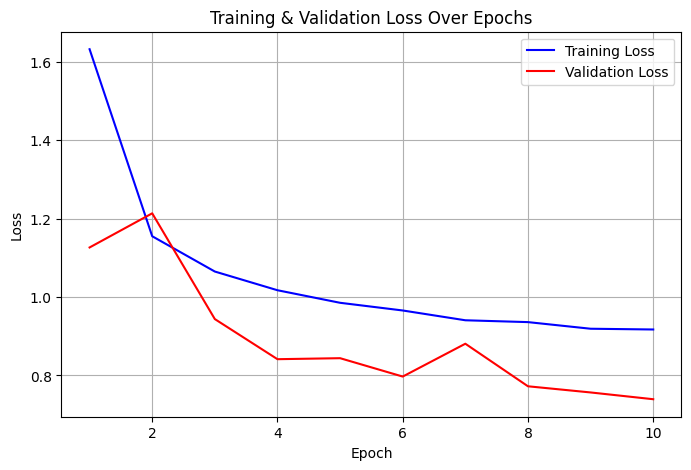

In [23]:
plot_loss(train_losses, val_losses)

Now do the same for Attention UNet and Reidual Attention UNet.

In [24]:
attention_unet = AttentionUNet().to(device)
criterion = OverallLoss()
# You can use other optimizers or Adam optimizer with customized weight decay, b1, or b2
optimizer = Adam(attention_unet.parameters(), lr=LR)

train_losses = []
val_losses = []

best_loss = 100.0
for i in range(NUM_EPOCHS):
    train_loss = train_one_epoch(attention_unet, optimizer, criterion, train_loader, device=device)
    val_loss, iou_score, dice_score = evaluate_model(attention_unet, criterion, val_loader, device=device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(attention_unet.state_dict(), "best_attention_unet.pth")

    print(f"Iteration {i+1}/{NUM_EPOCHS}: "
          f"Train Loss: {train_loss:.2f} | "
          f"Val Loss: {val_loss:.2f} | "
          f"Iou Score: {iou_score:.2f} | "
          f"Dice Score: {dice_score:.2f}")

100%|██████████| 2/2 [00:00<00:00,  5.03it/s]


Iteration 1/10: Train Loss: 1.62 | Val Loss: 1.18 | Iou Score: 0.45 | Dice Score: 0.62


100%|██████████| 2/2 [00:00<00:00,  4.96it/s]


Iteration 2/10: Train Loss: 1.17 | Val Loss: 1.67 | Iou Score: 0.36 | Dice Score: 0.52


100%|██████████| 2/2 [00:00<00:00,  4.87it/s]


Iteration 3/10: Train Loss: 1.08 | Val Loss: 0.90 | Iou Score: 0.58 | Dice Score: 0.74


100%|██████████| 2/2 [00:00<00:00,  5.11it/s]


Iteration 4/10: Train Loss: 1.01 | Val Loss: 0.92 | Iou Score: 0.59 | Dice Score: 0.74


100%|██████████| 2/2 [00:00<00:00,  5.01it/s]


Iteration 5/10: Train Loss: 0.98 | Val Loss: 0.81 | Iou Score: 0.63 | Dice Score: 0.77


100%|██████████| 2/2 [00:00<00:00,  5.03it/s]


Iteration 6/10: Train Loss: 0.96 | Val Loss: 0.81 | Iou Score: 0.63 | Dice Score: 0.77


100%|██████████| 2/2 [00:00<00:00,  4.93it/s]


Iteration 7/10: Train Loss: 0.93 | Val Loss: 0.78 | Iou Score: 0.64 | Dice Score: 0.78


100%|██████████| 2/2 [00:00<00:00,  4.81it/s]


Iteration 8/10: Train Loss: 0.92 | Val Loss: 0.78 | Iou Score: 0.65 | Dice Score: 0.79


100%|██████████| 2/2 [00:00<00:00,  5.04it/s]


Iteration 9/10: Train Loss: 0.91 | Val Loss: 0.76 | Iou Score: 0.65 | Dice Score: 0.79


100%|██████████| 2/2 [00:00<00:00,  4.59it/s]

Iteration 10/10: Train Loss: 0.90 | Val Loss: 0.78 | Iou Score: 0.64 | Dice Score: 0.78


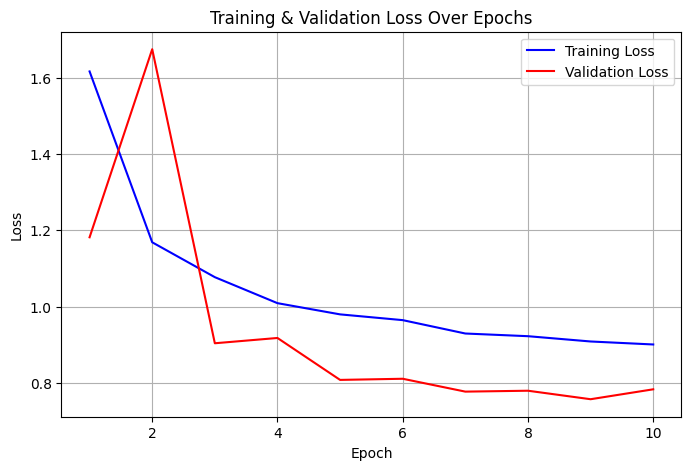

In [25]:
plot_loss(train_losses, val_losses)

For Residual Attention UNet, plot the changes in train and validation loss.

In [26]:
resattn_unet = ResidualAttentionUNet().to(device)
criterion = OverallLoss()
# You can use other optimizers or Adam optimizer with customized weight decay, b1, or b2
optimizer = Adam(resattn_unet.parameters(), lr=LR)

train_losses = []
val_losses = []

best_loss = 100.0
for i in range(NUM_EPOCHS):
    train_loss = train_one_epoch(resattn_unet, optimizer, criterion, train_loader, device=device)
    val_loss, iou_score, dice_score = evaluate_model(resattn_unet, criterion, val_loader, device=device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(resattn_unet.state_dict(), "best_residual_attention_unet.pth")

    print(f"Iteration {i+1}/{NUM_EPOCHS}: "
          f"Train Loss: {train_loss:.2f} | "
          f"Val Loss: {val_loss:.2f} | "
          f"Iou Score: {iou_score:.2f} | "
          f"Dice Score: {dice_score:.2f}")

100%|██████████| 2/2 [00:00<00:00,  4.57it/s]


Iteration 1/10: Train Loss: 1.49 | Val Loss: 1.05 | Iou Score: 0.52 | Dice Score: 0.68


100%|██████████| 2/2 [00:00<00:00,  4.58it/s]


Iteration 2/10: Train Loss: 1.12 | Val Loss: 1.00 | Iou Score: 0.54 | Dice Score: 0.70


100%|██████████| 2/2 [00:00<00:00,  4.34it/s]


Iteration 3/10: Train Loss: 1.02 | Val Loss: 0.84 | Iou Score: 0.60 | Dice Score: 0.75


100%|██████████| 2/2 [00:00<00:00,  4.49it/s]


Iteration 4/10: Train Loss: 0.98 | Val Loss: 0.80 | Iou Score: 0.63 | Dice Score: 0.77


100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


Iteration 5/10: Train Loss: 0.96 | Val Loss: 0.80 | Iou Score: 0.63 | Dice Score: 0.77


100%|██████████| 2/2 [00:00<00:00,  4.50it/s]


Iteration 6/10: Train Loss: 0.92 | Val Loss: 0.78 | Iou Score: 0.64 | Dice Score: 0.78


100%|██████████| 2/2 [00:00<00:00,  4.48it/s]


Iteration 7/10: Train Loss: 0.90 | Val Loss: 0.76 | Iou Score: 0.66 | Dice Score: 0.79


100%|██████████| 2/2 [00:00<00:00,  3.90it/s]


Iteration 8/10: Train Loss: 0.89 | Val Loss: 0.76 | Iou Score: 0.66 | Dice Score: 0.79


100%|██████████| 2/2 [00:00<00:00,  4.20it/s]


Iteration 9/10: Train Loss: 0.87 | Val Loss: 0.72 | Iou Score: 0.66 | Dice Score: 0.80


100%|██████████| 2/2 [00:00<00:00,  4.00it/s]


Iteration 10/10: Train Loss: 0.87 | Val Loss: 0.72 | Iou Score: 0.67 | Dice Score: 0.80


Now Visualize losses.

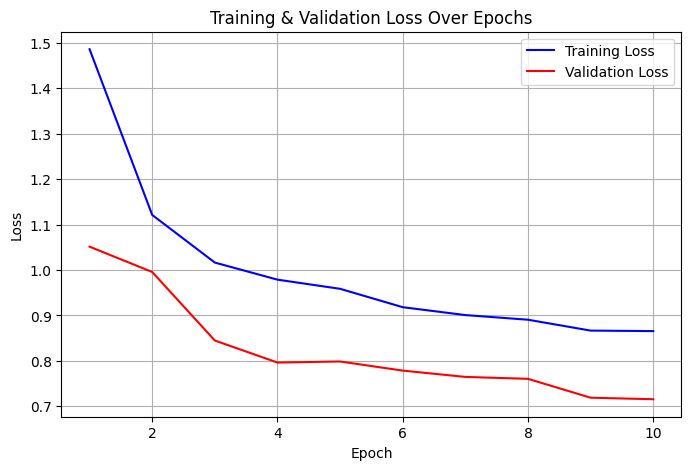

In [28]:
plot_loss(train_losses, val_losses)

### Prediction Visualisation

Display several images, their masks, and the predicted mask by your model.

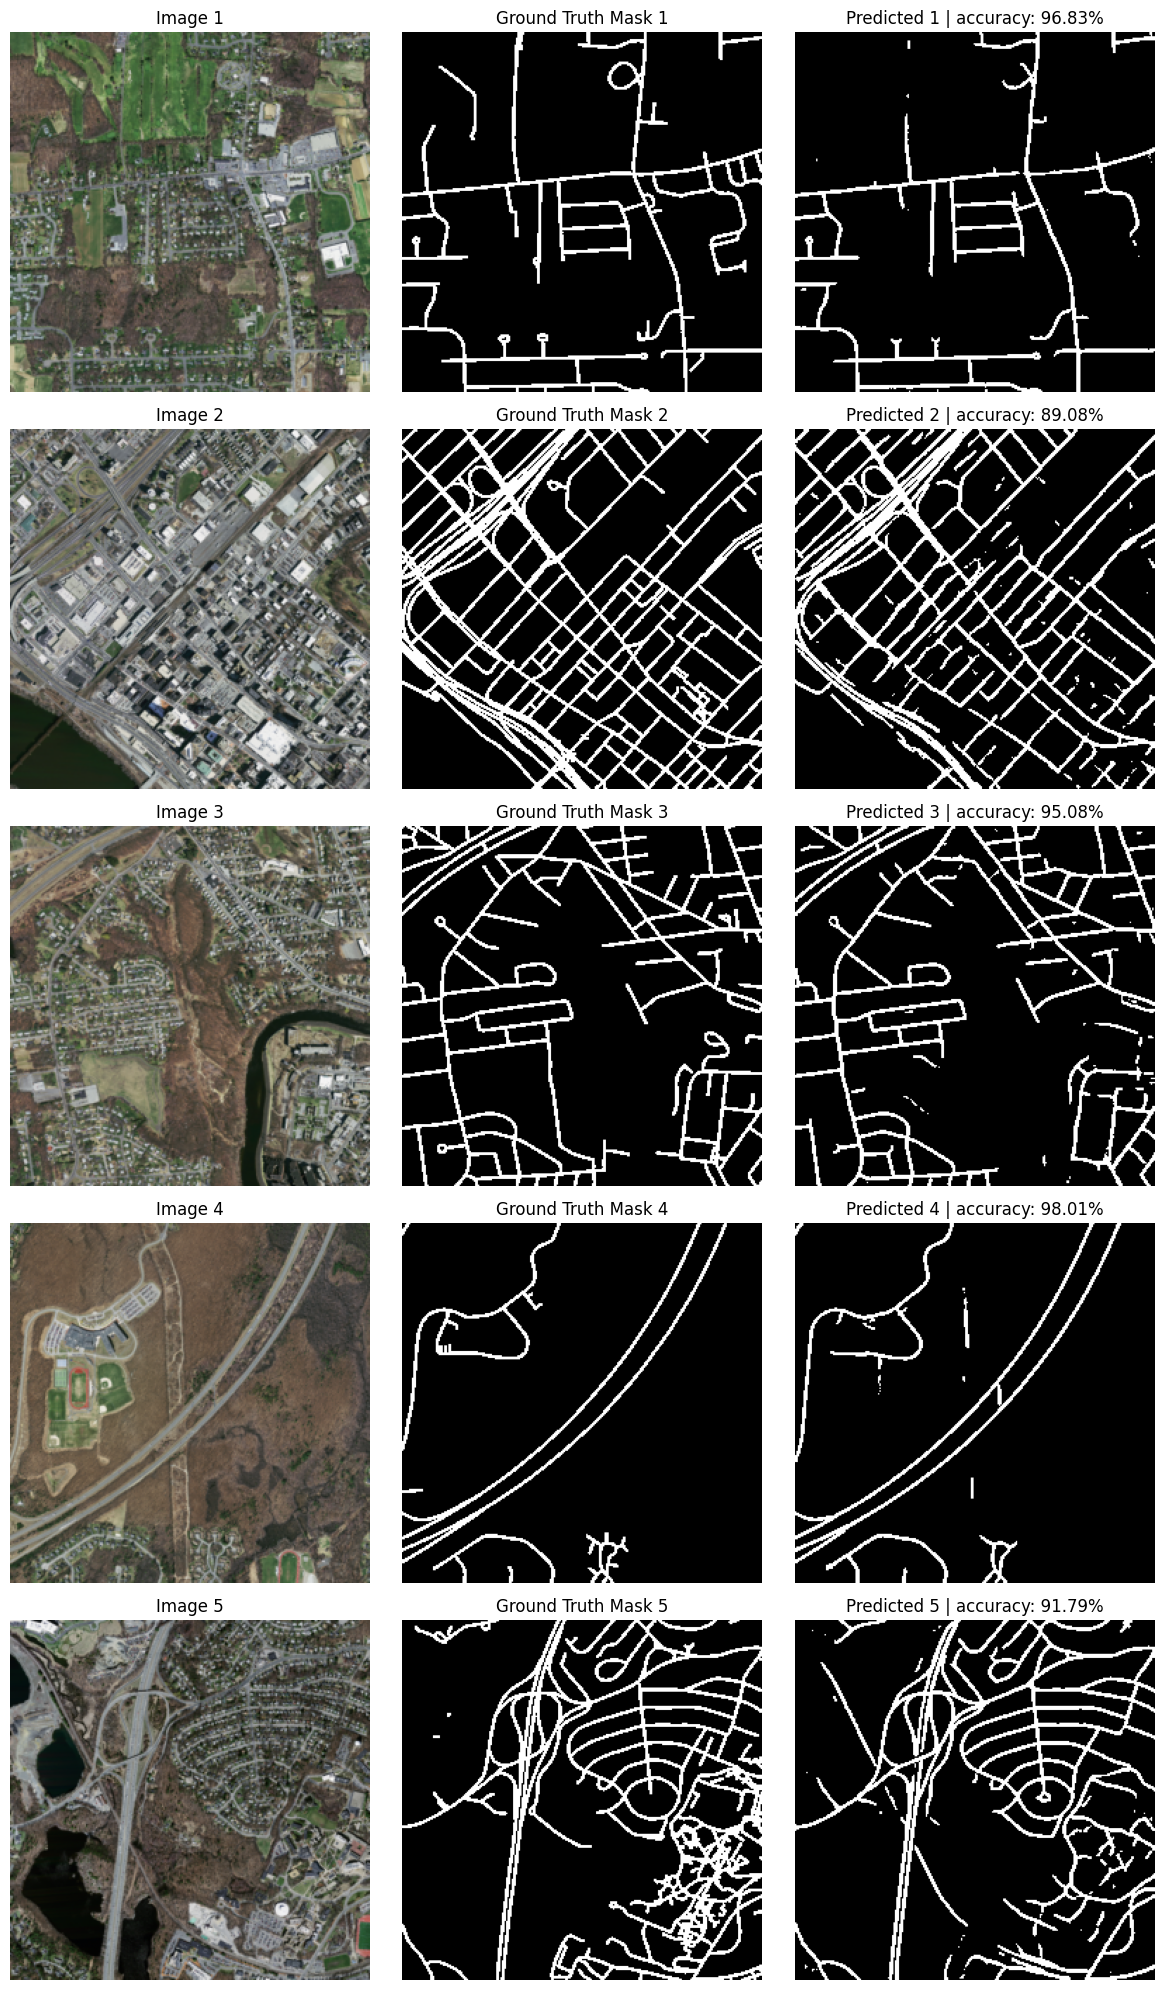

In [33]:
def visualize_image_mask_prediction(images, masks, predictions, accuracies, n=5):
    plt.figure(figsize=(12, 4 * n))

    for i in range(n):
        # Original Image
        plt.subplot(n, 3, 3 * i + 1)
        plt.imshow(images[i])
        plt.title(f'Image {i+1}')
        plt.axis('off')

        # Ground Truth Mask
        plt.subplot(n, 3, 3 * i + 2)
        plt.imshow(masks[i], cmap='gray')
        plt.title(f'Ground Truth Mask {i+1}')
        plt.axis('off')

        # Predicted Mask
        plt.subplot(n, 3, 3 * i + 3)
        plt.imshow(predictions[i], cmap='gray')
        plt.title(f'Predicted {i+1} | accuracy: {accuracies[i]:.2f}%')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = UNet().to(device)
model.load_state_dict(torch.load("best_unet.pth"))
model.eval()

with torch.no_grad():
    sample_images, sample_masks = next(iter(val_loader))
    sample_images = sample_images.to(device)
    predictions = model(sample_images)
    predictions = torch.sigmoid(predictions)
    predictions_bin = (predictions > 0.5).float()

    # Convert tensors to numpy arrays for visualization
    sample_images_np = sample_images.cpu().numpy()
    sample_masks_np = sample_masks.cpu().numpy()
    predictions_np = predictions_bin.cpu().numpy()

    # Compute pixel-wise accuracies
    accuracies = []
    for i in range(len(sample_masks_np)):
        gt = sample_masks_np[i].astype(np.uint8)
        pred = predictions_np[i].astype(np.uint8)
        correct = (gt == pred).sum()
        total = gt.size
        accuracies.append(100 * correct / total)

    # Denormalize original images for better visualization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    for i in range(sample_images_np.shape[0]):
        for c in range(3):
            sample_images_np[i, c] = sample_images_np[i, c] * std[c] + mean[c]

    sample_images_np = np.transpose(sample_images_np, (0, 2, 3, 1))
    sample_masks_np = sample_masks_np.squeeze()
    predictions_np = predictions_np.squeeze()

    visualize_image_mask_prediction(sample_images_np, sample_masks_np, predictions_np, accuracies, n=5)